<a href="https://colab.research.google.com/github/sigopt/sigopt-examples/blob/experiment-management/surprise_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

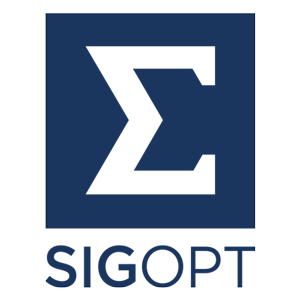

Recommendation systems are some of the most fundamental and useful applications that machine learning can deliver to businesses. Also known as recommender systems, these algorithms typically suggest what movie to watch next, what blog to read, or which product to buy.

Today we'll use a dataset from [MovieLens](https://grouplens.org/datasets/movielens/), featuring movie reviews in plaintext right alongside various scores, associated with specific users and specific films. This dataset is built right into Surprise, which leverages the scikit model, the most famouse example of which is likely scikit-learn, which we've explored in the past, and will use again in a future blog post on Natural Language.

[Surprise](http://surpriselib.com/) is both useful and simple because it can train a model that serves recommendations by using simple annotated data that includes fields for user ratings, item ratings, total user counts, item counts, ratings, and rating scale, all of which is required to build a simple recommender system.

Meanwhile, Surprise includes the SVD algorithm as standard, similar to Probabilistic Matirx Factorization, that became popular thanks to the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize), a recommendation systems copmetition that took place over multilple years, between 2006 and 2009.

Here we'll look at two standard metrics, RMSE (root mean squared error) and MAE (mean average error) with cross-validation on a 5-way split. We'll later compare this result to a simpler 3-way random test-train-evaluation split.

In [ ]:
!pip install scikit-surprise
# !conda install -y -c conda-forge scikit-surprise # If you use conda on a non-Colab environment

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin(name='ml-100k', prompt=False)

# Or if you'd rather, comment the above line and uncomment the below line 
# for a larger data set, while anticipating longer training times.

# data = Dataset.load_builtin(name='ml-1M', prompt=False)

# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

## Splitting up the dataset:

This time we'll simply use a training set and a test set, as is both common and standard in scikit-learn:

In [ ]:
from surprise import accuracy
from sklearn.metrics import mean_absolute_error
from surprise.model_selection import train_test_split

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

The above result seems fairly reasonable, but it stands to reason that with either tweaking or tuning, we might do a little better. Let's start off with the exhaustive and typicaly time-consuming approach, grid search.

## Set a baseline with a simple grid search:

In [ ]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

But can we still improve? Of course we can. SigOpt's ensemble, including Bayesian Optimization, will very likely deliver a lower RMSE score. Let's try it out now.

If you don't yet have an account or an API key, you can [sign up for free here](https://app.sigopt.com/signup). If you click on your name at top left, you should see an "API Tokens" link where you will find your main "API Token." You should paste that in the following cell:

In [ ]:
!pip install sigopt
# Pass your API token directly, overriding any environment variables
from sigopt import Connection
conn = Connection(client_token="YOUR_API_TOKEN_HERE")

Now that we've successfully connected to SigOpt, it's time to define the parameters we'd like to optimize. As you can see, n_epochs is an integer, which you can increase if you're willing to spend more time training. Training time is also dependent on dataset size, so if you opted for the larger MovieLens variant, it may make sense to keep the range of epochs you wish to explore a little smaller here.

In [ ]:
experiment = conn.experiments().create(
  name='Surprise Movies-100k Recommender',
  # Define which parameters you would like to tune
  parameters=[
    dict(name='n_epochs', type='int', bounds=dict(min=5, max=10)),
    dict(name='lr_all', type='double', bounds=dict(min=0.002, max=0.005)),
    dict(name='reg_all', type='double', bounds=dict(min=0.4, max=0.6))
  ],
  metrics=[
    dict(name='RMSE', objective='minimize', strategy='optimize'),
    dict(name='MAE', objective='minimize', strategy='store')
  ],
  parallel_bandwidth=1,
  # Define an Observation Budget for your experiment
  observation_budget=50,
)
print("Created experiment: https://app.sigopt.com/experiment/" + experiment.id)

Although you can take a look at your experiment page now, it will be empty: we still need to define the functions required to create the model, and then evaluate its performance on the metrics we specified above, RMSE and MAE.

In [ ]:
# Evaluate your model with the suggested parameter assignments
def create_model(assignments):
  algo = SVD(
      n_epochs=assignments['n_epochs'],
      lr_all=assignments['lr_all'],
      reg_all=assignments['reg_all']
  ).fit(trainset)
  return algo

def evaluate_model(assignments):
  algo = create_model(assignments)
  predictions = algo.test(testset)
  # Then compute RMSE and MAE:
  return [
      dict(name="RMSE", value=accuracy.rmse(predictions)),
      dict(name="MAE", value=accuracy.mae(predictions))
    ]

Now we'll run the optimization loop. Note that we are are tracking "values" instead of "value" because we have multiple metrics. In this case, we're choosing to optimize against only one, but it is possible to optimize against both. Because these metrics should be related by a scaling factor, I wouldn't expect to see much benefit from optimizing against both.

*Note:*

The full 60 epochs we've specified here will take roughly 5 minutes to complete on the 100k dataset.

In [ ]:
# Run the Optimization Loop until the Observation Budget is exhausted
while experiment.progress.observation_count < experiment.observation_budget:
  suggestion = conn.experiments(experiment.id).suggestions().create()
  value_dicts = evaluate_model(suggestion.assignments)
  conn.experiments(experiment.id).observations().create(
    suggestion=suggestion.id,
    values=value_dicts,
  )

  # Update the experiment object
  experiment = conn.experiments(experiment.id).fetch()

# Fetch the best configuration and explore your experiment
all_best_assignments = conn.experiments(experiment.id).best_assignments().fetch()
# Returns a list of dict-like Observation objects
best_assignments = all_best_assignments.data[0].assignments
print("Best Assignments: " + str(best_assignments))
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

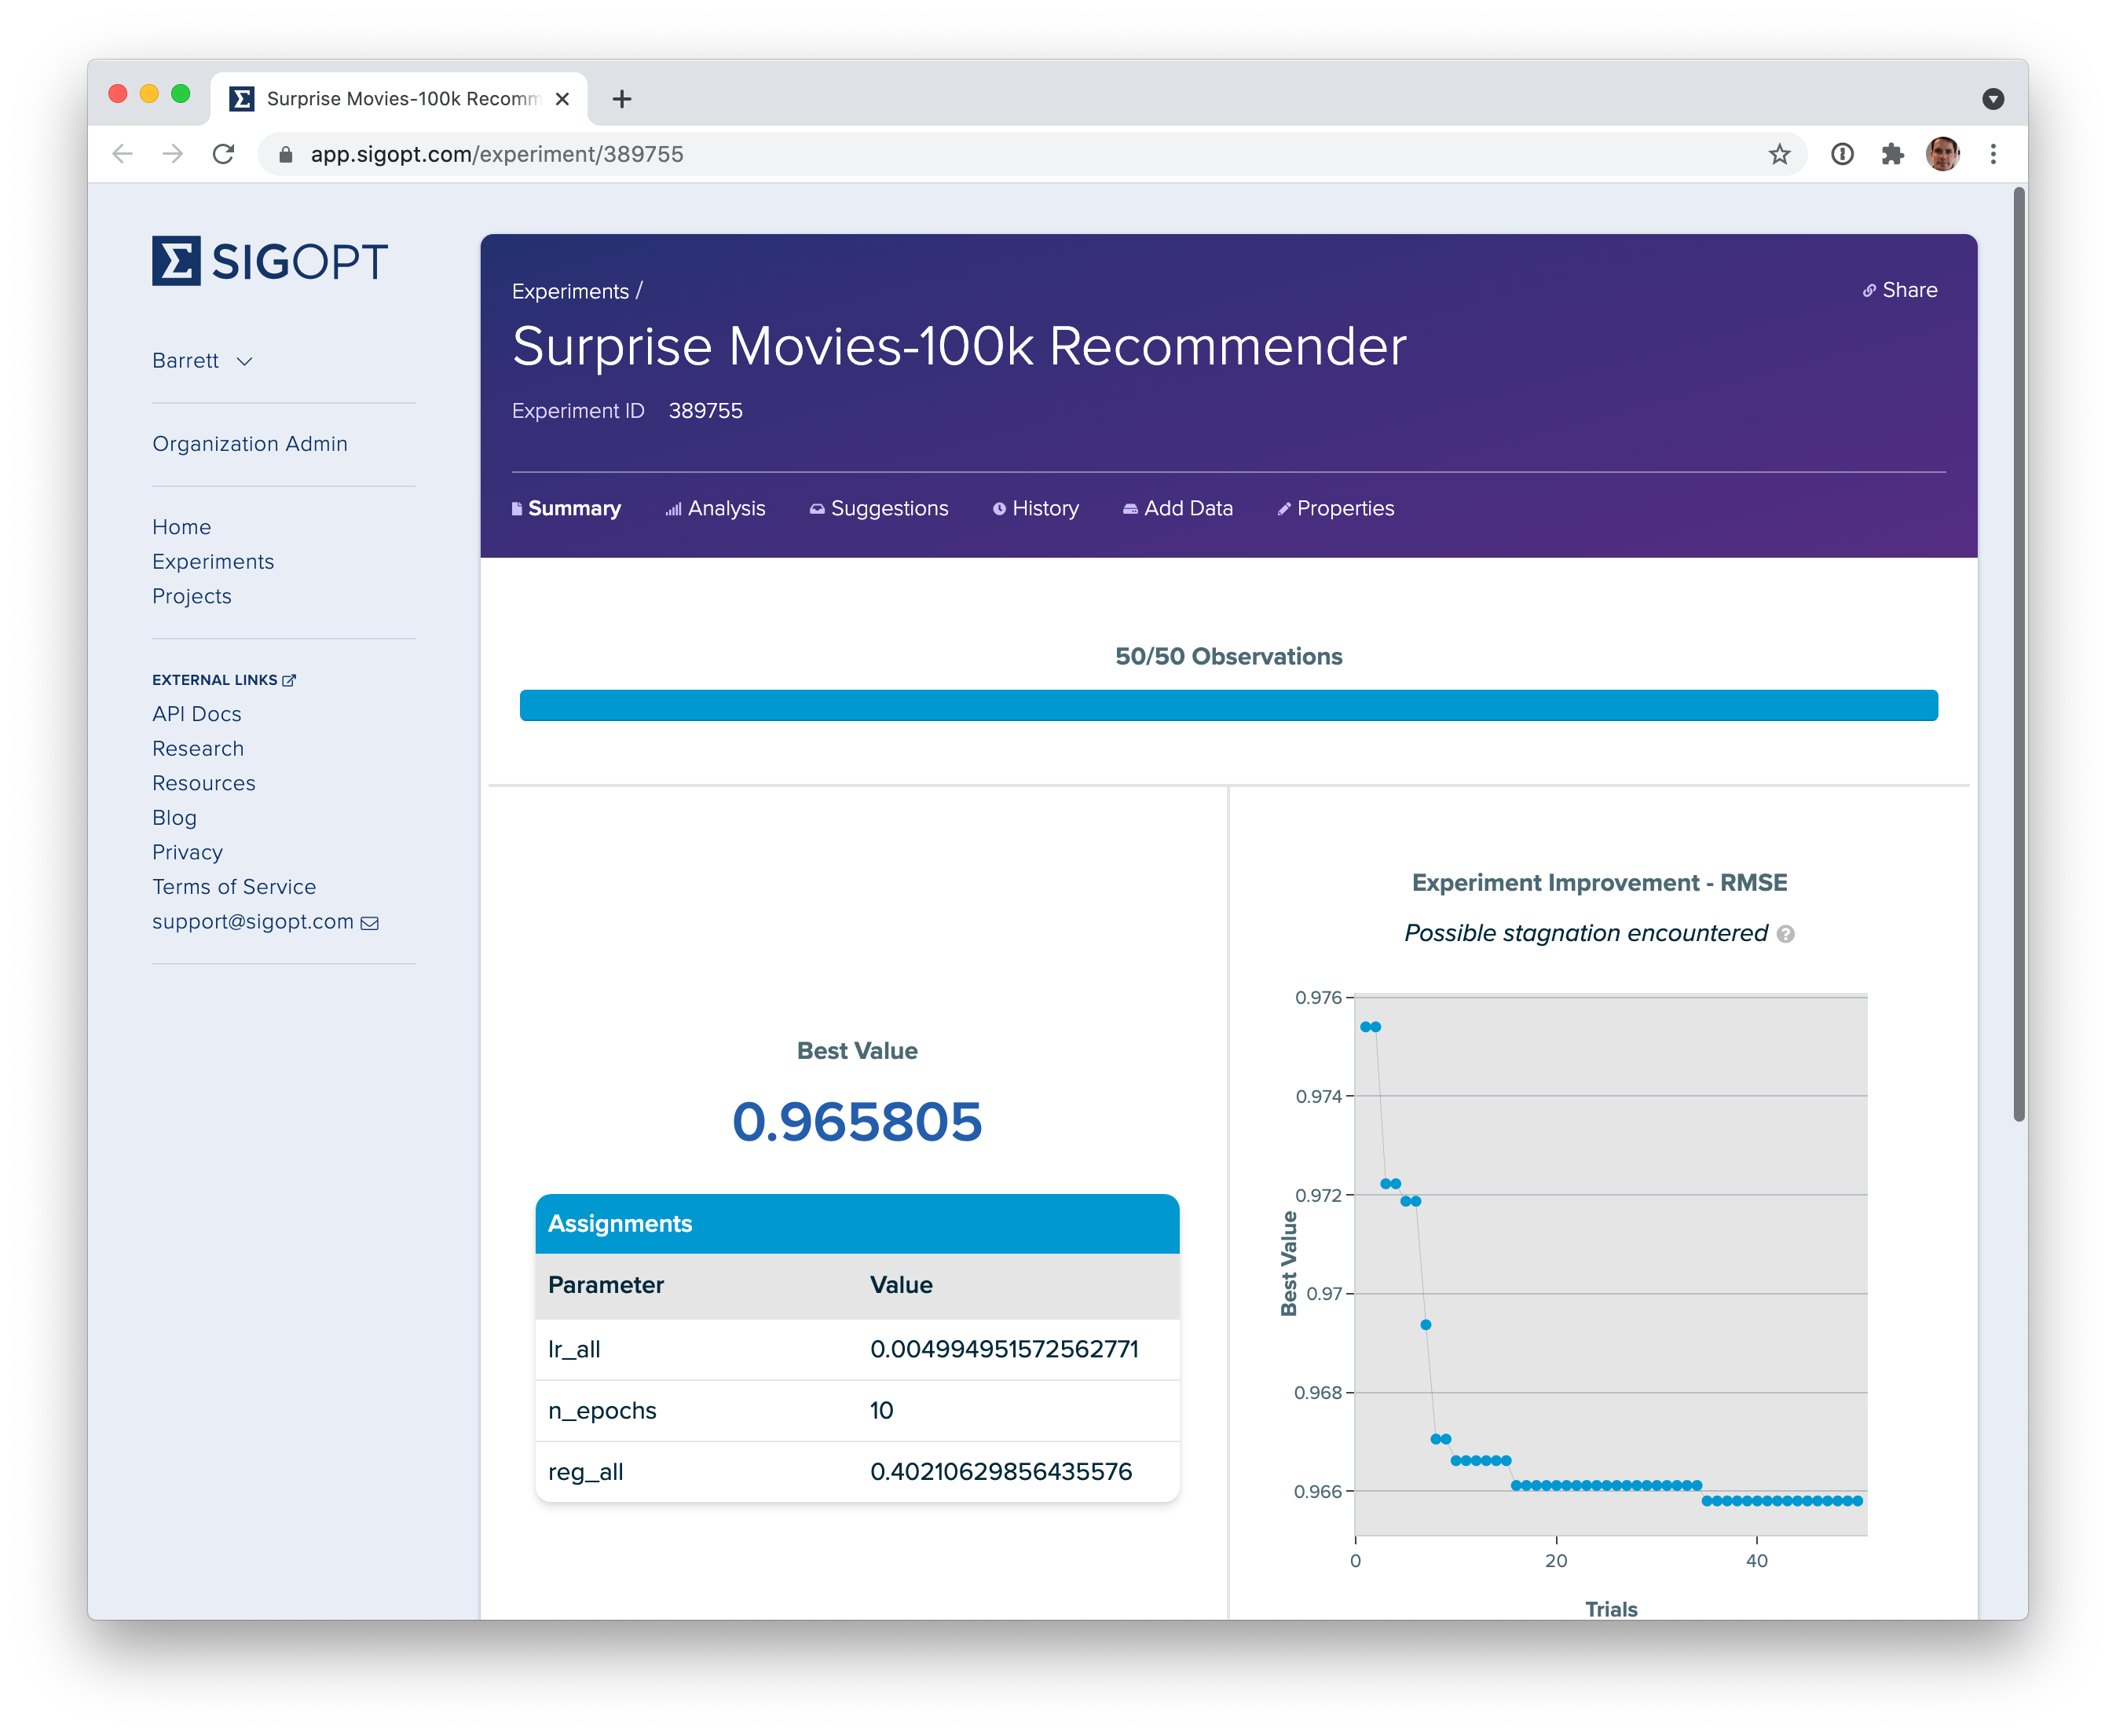

As you can see from the above metric trajectory, we've improved markedly on our grid search results, and really only needed 40 or so experimentation loops for this particular problem. On your own, you may find that more epochs are required for improved performance on the larger (1M row) Movielens dataset.

Credit goes to Nicolas Hug from Facebook AI Research (FAIR) for implementing and maintaining scikit-surprise. You can find the documentation [here](https://surprise.readthedocs.io/en/stable/getting_started.html) from which these SigOpt-enhanced examples were developed, and without which this work would not be possible! Kudos to Nicolas for building such a simple and elegant library.

If you'd like to try another Spark MLLib recommender system that uses Collaborative Filtering, you can [find that code example here](https://github.com/sigopt/sigopt-examples/tree/master/spark/recommender_sys).

Thanks for trying out this example today, and if you'd like to be notified of more technical content in the future, be sure to [sign up for updates here](https://modeling.sigopt.com/blogupdates).
